# Poisoning Attacks against Machine Learning models

In this tutorial we will experiment with **adversarial poisoning attacks** 
 against a Support Vector Machine (SVM) with Radial Basis Function (RBF) kernel.

Poisoning attacks are performed at *train time* by injecting *carefully crafted 
 samples* that alter the classifier decision function so that its accuracy decreases.

As in the previous tutorials, we will first create and train the classifier, 
 evaluating its performance in the standard scenario, *i.e. not under attack*.
 The poisoning attack will also need a *validation set* to verify the classifier
 performance during the attack, so we split the training set furtherly in two.

In [1]:
random_state = 999

n_features = 2  # Number of features
n_samples = 300  # Number of samples
centers = [[-1, -1], [+1, +1]]  # Centers of the clusters
cluster_std = 0.9  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features, 
                         centers=centers, 
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 100  # Number of training set samples
n_val = 100  # Number of validation set samples
n_ts = 100  # Number of test set samples

# Split in training, validation and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernel import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF())

# Parameters for the Cross-Validation procedure
xval_params = {'C': [1e-2, 0.1, 1], 'kernel.gamma': [1, 10, 100]}

# Let's create a 3-Fold data splitter
from secml.data.splitter import CDataSplitterKFold
xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

# Select and set the best training parameters for the classifier
print("Estimating the best training parameters...")
best_params = clf.estimate_parameters(
    dataset=tr, 
    parameters=xval_params, 
    splitter=xval_splitter, 
    metric='accuracy', 
    perf_evaluator='xval'
)

print("The best training parameters are: ", best_params)

# We can now fit the classifier
clf.fit(tr)
print("Training of classifier complete!")

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

Estimating the best training parameters...
The best training parameters are:  {'kernel.gamma': 10, 'C': 0.1}
Training of classifier complete!


## Generation of Poisoning Samples

We are going to generate an adversarial example against the SVM classifier
 using the **gradient-based** algorithm for generating poisoning attacks 
 proposed in: 
 
  > [[biggio12-icml]](https://arxiv.org/abs/1206.6389)
  > Biggio, B., Nelson, B. and Laskov, P., 2012. Poisoning attacks against 
  > support vector machines. In ICML 2012.

  > [[biggio15-icml]](https://arxiv.org/abs/1804.07933)
  > Xiao, H., Biggio, B., Brown, G., Fumera, G., Eckert, C. and Roli, F., 2015. 
  > Is feature selection secure against training data poisoning?. In ICML 2015.

  > [[demontis19-usenix]](
  > https://www.usenix.org/conference/usenixsecurity19/presentation/demontis)
  > Demontis, A., Melis, M., Pintor, M., Jagielski, M., Biggio, B., Oprea, A., 
  > Nita-Rotaru, C. and Roli, F., 2019. Why Do Adversarial Attacks Transfer? 
  > Explaining Transferability of Evasion and Poisoning Attacks. In 28th Usenix 
  > Security Symposium, Santa Clara, California, USA.

which is implemented in SecML by different subclasses of the `CAttackPoisoning`.
 For the purpose of attacking a SVM classifier we use the `CAttackPoisoningSVM` 
 class.

As done for the [evasion attacks](02-Evasion.ipynb), let's specify the 
 parameters first. We set the bounds of the attack space to the known feature
 space given by validation dataset. Secondly, we set the desired number of 
 adversarial points to generate, 20 in this example. Lastly, we chose the 
 solver parameters for this specific optimization problem.

In [2]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded
n_poisoning_points = 20  # Number of poisoning points to generate

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05, 
    'eta_min': 0.05, 
    'eta_max': None, 
    'max_iter': 100, 
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  surrogate_classifier=clf,
                                  surrogate_data=tr,
                                  val=val,
                                  lb=val.X.min(), ub=val.X.max(),
                                  solver_params=solver_params,
                                  random_seed=random_state)
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y, max_iter=10)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 94.00%
Accuracy after attack on test set: 93.00%


We can see that the classifiers has been successfully attacked. To increase 
the attack power, more poisoning points can be crafted, at the expense of 
 a much slower optimization process.

Let's now visualize the attack on a 2D plane. We need to train a copy of the 
original classifier on the join between the training set and the poisoning points.

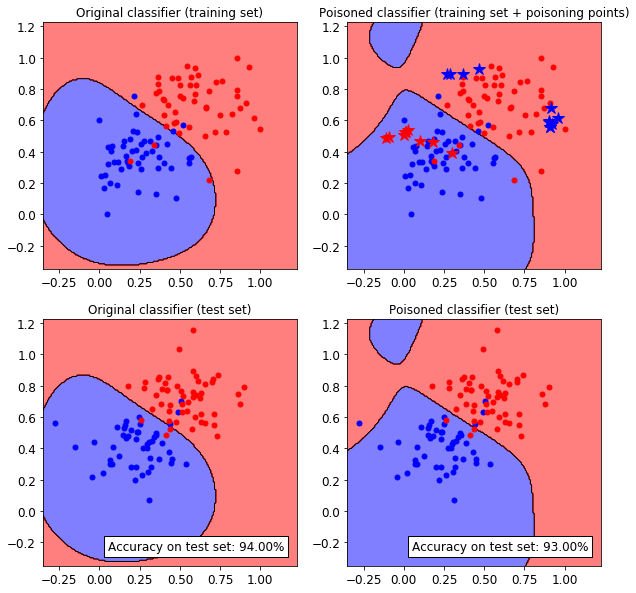

In [4]:
# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

from secml.figure import CFigure
fig = CFigure(10, 10)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()

We can see how the SVM classifier decision functions *changes* after injecting
 the adversarial poisoning points (blue and red stars).
 
For more details about poisoning adversarial attacks please refer to:

  > [[biggio18-pr]](https://arxiv.org/abs/1712.03141)
  > Biggio, B. and Roli, F., 2018. Wild patterns: Ten years after the rise of 
  > adversarial machine learning. In Pattern Recognition.